In [166]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
%matplotlib inline

### Lab 18 - Interior Points 1 Linear Programs

#### Coding Interior Point Function

In [161]:
def interiorPoint(A, b, c, niter = 20, tol = 1e-6):
    m, n = np.shape(A)
    
    # Coding Dual Conditions
    def KKT(x, l, mu):
        F = np.zeros(2*n+m)
        F[:n] = A.T.dot(l) + mu - c
        F[n:n+m] = A.dot(x) - b
        F[n+m:2*n+m] =  np.diag(mu).dot(x)
        return F
    
    # Initializing static 2/3rds of Total Derivative of F
    A1 = np.hstack((np.zeros((n,n)), A.T, np.eye(n)))
    A2 = np.hstack((A, np.zeros((m,m+n))))
    A12 = np.vstack((A1, A2))
                   
    # Writing solver for search direction
    def SD(x, l, mu):
        A3 = np.hstack((np.diag(mu), np.zeros((n,m)), np.diag(x)))
        lhs = np.vstack((A12, A3))
        rhs = - KKT(x, l, mu) + np.concatenate((np.zeros(n),np.zeros(m), (1/10)*(np.dot(x, mu)/n)*np.ones(n)))
        #Factorize A and solve using lu_solve
        sd = la.lu_solve(la.lu_factor(lhs), rhs)
        xstep = sd[:n]
        lstep = sd[n:n+m]
        mustep= sd[n+m: 2*n + m]
        return xstep, lstep, mustep
    
    # Finding Step Size
    def step(x,l,mu):
        xstep, lstep, mustep = SD(x,l,mu)        
        # Finding amax
        index = np.where(mustep < 0)
        amax = min(1, np.min(-mu[index]/mustep[index]))
        index2 = np.where(xstep < 0)
        dmax = min(1, np.min(-x[index2]/xstep[index2]))
        a = min(1, 0.95*amax)
        d = min(1, 0.95*dmax)
        return a, d
    
    #Starting point
    def starting_point(A, b, c):
        '''Calculate an initial guess to the solution of the linear program
        min c^T x, Ax = b, x >= 0
        Nodel and Wright, p.410. '''
        # Calculate x, l, mu of minimal form satisfying both
        # the primal and dual constraints
        B = la.inv(A.dot(A.T))
        x = A.T.dot(B.dot(b))
        l = B.dot(A.dot(c))
        mu = c - A.T.dot(l)
        
        # Perturb x and s so they are nonnegative
        dx = max((-3./2)*x.min(), 0)
        dmu = max((-3./2)*mu.min(), 0)
        x += dx*np.ones_like(x)
        mu += dmu*np.ones_like(mu)
        
        # Perturb x and mu so that they are not too small
        #and not too dissimilar
        dx = .5*(x*mu).sum()/mu.sum()
        dmu = .5*(x*mu).sum()/x.sum()
        x += dx*np.ones_like(x)
        mu += dmu*np.ones_like(mu)
        
        return x, l, mu
    
    #Iterate to solve
    x0, l0, m0 = starting_point(A, b, c)
    error = 1
    it = 0

    while error > tol and it < niter:
        xstep, lstep, mustep = SD(x0, l0 ,m0)
        astep, dstep = step(x0, l0, m0)
        x1 = x0 + dstep*xstep
        l1 = l0 + astep*lstep
        m1 = m0 + astep*mustep
        error = abs(np.dot(x1, m1)/n)
        print("Iteration = ", it, "Error = ", error)
        it += 1
        x0, l0, m0 = x1, l1, m1
    
    return x0, np.dot(c, x0)

In [84]:
def randomLP(m,n):
    '''Generate a linear program min c^T x s.t. Ax = b, x > 0.
    First generate m feasible constraints, then add slack variables
    to convert it into the above form
    Inputs:
        m(int >= n): number of desired constraints
        n(int): dimension of space in which to optimize
    Outputs:
        A ((m, m+n), ndarray): Constraint matrix
        b((m,), ndarray): Constraint vector
        c((n+m,), ndarray): Objective Function
        x((n,), ndarray): First 'n' terms to the solution of the lp
    '''
    A = np.random.random((m,n))*20 - 10
    A[A[:,1]<0] *= -1
    x = np.random.random(n)*10
    b = np.zeros(m)
    b[:n] = A[:n,:].dot(x)
    b[n:] = A[n:,:].dot(x) + np.random.random(m-n)*10
    c = np.zeros(n+m)
    c[:n] = A[:n,:].sum(axis = 0)/n
    A = np.hstack((A, np.eye(m)))
    return A, b, -c, x


In [162]:
m, n = 3,2
A, b, c, x = randomLP(m,n)
points, values = interiorPoint(A, b, c)
np.allclose(x, points[:n])

Iteration =  0 Error =  0.49276415603
Iteration =  1 Error =  0.109189901628
Iteration =  2 Error =  0.0162502737443
Iteration =  3 Error =  0.00235894609842
Iteration =  4 Error =  0.000342069881085
Iteration =  5 Error =  4.96003099484e-05
Iteration =  6 Error =  7.19204626139e-06
Iteration =  7 Error =  1.04284671755e-06
Iteration =  8 Error =  1.51212774115e-07


True

#### Problem 6

In [163]:
# Loading Data
simdata = np.loadtxt('simdata.txt')

# Initializing vectors c and y
m, n = simdata.shape[0], simdata.shape[1] - 1
c = np.zeros(3*m +2*(n+1))
c[:m] = 1
y = np.empty(2*m)
y[::2] = -simdata[:,0]
y[1::2] = simdata[:,0]
x = simdata[:,1:]

# Writing constraint matrix
A = np.ones((2*m, 3*m+2*(n+1)))
A[::2,:m] = np.eye(m)
A[1::2, :m] = np.eye(m)
A[::2, m:m+n] = -x
A[1::2, m:m+n] = x
A[::2, m+n:m+2*n] = x
A[1::2, m+n:m+2*n] = -x
A[::2, m+2*n] = -1
A[1::2, m+2*n+1] = -1
A[:, m+2*n+2:] = - np.eye(2*m, 2*m)

sol = interiorPoint(A, y, c)[0]

#Backing out Solutions for coefficients
beta = sol[m:m+n] - sol[m+n:m+2*n]
b = sol[m+2*n] - sol[m+2*n+1]

Iteration =  0 Error =  5.56504917092
Iteration =  1 Error =  2.10227818619
Iteration =  2 Error =  0.944693624302
Iteration =  3 Error =  0.341864719848
Iteration =  4 Error =  0.154121346483
Iteration =  5 Error =  0.0861098797319
Iteration =  6 Error =  0.0468206536254
Iteration =  7 Error =  0.0174492938866
Iteration =  8 Error =  0.00441459826362
Iteration =  9 Error =  0.00107540974984
Iteration =  10 Error =  0.000407951842388
Iteration =  11 Error =  0.000113027223146
Iteration =  12 Error =  2.71460943895e-05
Iteration =  13 Error =  6.16992936206e-06
Iteration =  14 Error =  1.38280979354e-06
Iteration =  15 Error =  3.10801933988e-07


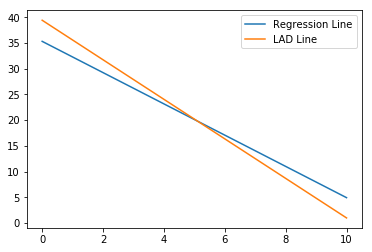

In [169]:
# Comparing results with regression
from scipy.stats import linregress
slope, intercept = linregress(simdata[:,1], simdata[:,0])[:2]
domain = np.linspace(0, 10, 200)
plt.plot(domain, domain*slope +intercept, label = 'Regression Line')
plt.plot(domain, domain*beta + b, label = 'LAD Line')
plt.legend()
plt.show()

### Lab 19 - Interior Point - Quadratic Programs

In [189]:
def qinteriorPoint(Q, A, b, c, guess, niter = 20, tol = 1e-6):
    m, n = np.shape(A)
    x0, y0, m0 = guess
    
    # Coding Dual Conditions
    def KKT(x, y, mu):
        F = np.zeros(2*m+n)
        F[:n] = Q.dot(x) - A.T.dot(mu) + c
        F[n:n+m] = A.dot(x) - y - b
        F[n+m:n+2*m] =  np.diag(y).dot(np.diag(mu).dot(np.ones(m)))
        return F
    
    # Initializing static 2/3rds of Total Derivative of F
    A1 = np.hstack((Q, np.zeros((n,m)), -A.T))
    A2 = np.hstack((A, -np.eye(m), np.zeros((m,m))))
    A12 = np.vstack((A1, A2))
                   
    # Writing solver for search direction
    def SD(x, y, mu):
        A3 = np.hstack((np.zeros((m,n)), np.diag(mu), np.diag(y)))
        lhs = np.vstack((A12, A3))
        rhs = - KKT(x, y, mu) + np.concatenate((np.zeros(n),np.zeros(m), (1/10)*(np.dot(y, mu)/m)*np.ones(m)))
        #Factorize A and solve using lu_solve
        sd = la.lu_solve(la.lu_factor(lhs), rhs)
        xstep = sd[:n]
        ystep = sd[n:n+m]
        mustep= sd[n+m: 2*m + m]
        return xstep, ystep, mustep
    
    # Finding Step Size
    def step(x,y,mu):
        xstep, ystep, mustep = SD(x,y,mu)        
        # Finding amax
        index = np.where(mustep < 0)
        bmax = min(1, np.min(-mu[index]/mustep[index]))
        index2 = np.where(ystep < 0)
        dmax = min(1, np.min(-y[index2]/ystep[index2]))
        b = min(1, 0.95*bmax)
        d = min(1, 0.95*dmax)
        a = min(b, d)
        return a
    
    #Starting point
    def starting_point(Q, A, b, c, guess):
        m, n = A.shape
        x0, y0, m0 = guess
        
        # Initialize Linear Systems
        N = np.zeros((n+m+m, n+m+m))
        N[:n,:n] = Q
        N[:n, n+m:] = -A.T
        N[n:n+m,:n] = A
        N[n:n+m, n:n+m] = -np.eye(m)
        N[n+m:, n:n+m] = np.diag(m0)
        N[n+m:, n+m:] = np.diag(y0)
        rhs = np.empty(n+m+m)
        rhs[:n] = -(Q.dot(x0) - A.T.dot(m0) + c)
        rhs[n:n+m] = -(A.dot(x0) - y0 - b)
        rhs[n+m:] = -(y0*m0)
        
        sol = la.solve(N, rhs)
        dx = sol[:n]
        dy = sol[n:n+m]
        dm = sol[n+m:]
        
        y0 = np.maximum(1, np.abs(y0 + dy))
        m0 = np.maximum(1, np.abs(m0 + dm))
        
        return x0, y0, m0
    
    #Iterate to solve
    x0, y0, m0 = starting_point(Q, A, b, c, guess)
    error = 1
    it = 0

    while error > tol and it < niter:
        xstep, ystep, mustep = SD(x0, y0 ,m0)
        astep = step(x0, y0, m0)
        x1 = x0 + astep*xstep
        y1 = y0 + astep*ystep
        m1 = m0 + astep*mustep
        error = abs(np.dot(y1, m1)/m)
        print("Iteration = ", it, "Error = ", error)
        it += 1
        x0, y0, m0 = x1, y1, m1
    
    return x0, np.dot(c, x0)

In [177]:
# Let us test this function on the example in the text.

Q = np.array([[1, -1],[-1,2]])
c = np.array([-2, -6])
A = np.array([[-1,-1],[1, -2],[-2,-1],[1,0],[0,1]])
b = np.array([-2,-2,-3,0,0])

guess = (np.array([0.5,0.5]),np.ones(5), np.ones(5)) 

In [190]:
qinteriorPoint(Q, A, b, c, guess)

Iteration =  0 Error =  0.250466780797
Iteration =  1 Error =  0.126003419989
Iteration =  2 Error =  0.0428048440472
Iteration =  3 Error =  0.00780515664659
Iteration =  4 Error =  0.00120645224731
Iteration =  5 Error =  0.000176277948144
Iteration =  6 Error =  2.55786408208e-05
Iteration =  7 Error =  3.70920346842e-06
Iteration =  8 Error =  5.37840205737e-07


(array([ 0.66666696,  1.33333287]), -9.3333311307129083)